# Finance NLP Sentiment Analysis and Topic Modelling
Sentiment analysis involves learning a model that can output a class label given a sequence of tokens. In the case of sentiment analysis, the possible classes are: positive, negative, neutral. For sentiment analysis we can use logistic regression. Other methods such as Naive Bayes are also possible, however, binary logistic regression is a discriminative classifier that unlike Naive Bayes does not assume that the features are conditionally independent given the class. We also have the benefit of a probability value for a document belonging to each class. In the context of sentiment analysis, logistic regression works by learning a linear combination of the features that are used to predict the probability of a input document being positive or
negative. $P(y|x)= \frac{1}{1+ \exp^{-\sum^{N}_{i=1}\theta_i \cdot x_i}}$ where $x_i$ is the value of the $i^{th}$ feature, $\theta_i$ is the weight of the 
$i^{th}$ feature, and $y$ is the class label (Jurafsky & Martin, 2021). The weights are learned by maximizing the likelihoods using the training data. To find the best θ we can use gradient descent.
As Mentioned previously, logistic regression utilises a liner combination of features to predict sentiment. Currently the documents from the FiQA Sentiment Analysis dataset are in the form of paragraphs and sentences. To utilise logistic regression some pre-processing of the data is required. Bag-of-words representation is used here (implimented with the word_tokenize module from NLTK), to provide numerical input to train our model. This approach splits the input document into a list of words used and the number of times that each occurs in the document. The downside of this is that information of word ordering is lost. Another approach is the use of lexicons. These are hand-crafted dictionaries of words with their associated sentiment. This has the advantage of including words that do not occur in the training data, if these were not included our classifiers performance would suffer in practice if it received unseen words which it must classify. When documents are tokenised (split into individual words) we lose information about word order. This means that more complex statements such as ‘not happy’ are likely to be mis-classified. To combat this, we can use bi_grams. This will join separate words tokens together. In this case bi-grams did not offer significant improvement when tested. Lemmatisation is another pre-processing approach that reduces words into their root form (lemma). By using a regular expressions (with the Python RE library and the word_tokenize module from NLTK) words are stripped of their stems and affixes meaning that words with the same root meaning can be compared. Different combinations of these approaches were tested and the best combination was: bag-of-words, lexicons and lemmatisation.

In [4]:
#Loading the data
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
train_files = [
    'data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [6]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding="utf-8") as handle:
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [7]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223


In [8]:
print(f'What does one instance look like from the training set? \n\n{train_documents[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

$REN bottoming out again.. Good time to buy
...and here is its corresponding label 

2


##  Preparing the Data
In order create a model that is capable of meaningful sentiment analysis we need to prepare the data. There is a multitude of methods avaialbe for this task, some of which are demonstrated below. 

###  Bag of Words

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

def process_tokenize(train_documents,val_documents):

    # CountVectorizer can do its own tokenization, but for consistency we want to
    # carry on using WordNetTokenizer. We write a small wrapper class to enable this:
    class Tokenizer(object):
        def __call__(self, tweets):
            return word_tokenize(tweets)

    vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer

    vectorizer.fit(train_documents)  # Learn the vocabulary
    X_train = vectorizer.transform(train_documents)  # extract training set bags of words
    X_test = vectorizer.transform(val_documents)  # extract test set bags of words
    return X_train, X_test

# X_train, X_test = process_tokenize(train_documents,val_documents)
X_train, X_test = process_tokenize(train_documents,test_documents)

/usr/local/anaconda3/envs/IDA/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Lemmatization
Lemmatization is the process of reducing a word to its root form (or lemma). This is based on the idea that words have an internal structure and are composed of stems and affixes. This is achieved by using a series of regular expressions. 

In [10]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

def process_lemmatize(X_train,X_test):

    class LemmaTokenizer(object):
        
        def __init__(self):
            self.wnl = WordNetLemmatizer()
            
        def __call__(self, tweets):
            return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
        
    vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())

    vectorizer.fit(train_documents)
    X_train = vectorizer.transform(train_documents)
    # X_test = vectorizer.transform(val_documents)
    X_test = vectorizer.transform(test_documents)
    return X_train, X_test

# X_train, X_test = process_lemmatize(train_documents,val_documents)

### NGrams
There is often some information about context lost when using unigrams. By using bigrams we can retain some of this information. This is not used because we do not have gold label data for bigrams.

In [11]:
def process_bigram(X_train,X_test):
    vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(2,2))
    vectorizer.fit(X_train)
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test

# X_train, X_test = process_bigram(test_documents,val_documents)
# X_train, X_test = process_bigram(test_documents,test_documents)

### Lexicons
All words can be associated with a sentiment. Our training data is not complete across the English language, lexicon allow us to fill this gap and train for words that may not be seen across the training data.

In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

class Tokenizer(object):
    def __call__(self, tweets):
        return word_tokenize(tweets)

nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()
def process_lexicon(train_documents,val_documents):
    vectorizer = CountVectorizer(tokenizer=Tokenizer())

    vectorizer.fit(train_documents)
    X_train = vectorizer.transform(train_documents)
    X_test = vectorizer.transform(val_documents)

    vocabulary = vectorizer.vocabulary_

    lex_pos_scores = np.zeros((1, len(vocabulary)))
    lex_neg_scores = np.zeros((1, len(vocabulary)))

    for i, term in enumerate(vocabulary):
        if term in analyser.lexicon and analyser.lexicon[term] > 0:
            lex_pos_scores[0, i] = 1
        elif term in analyser.lexicon and analyser.lexicon[term] < 0:
            lex_neg_scores[0, i] = 1


    lex_pos_train = np.sum(X_train.multiply(lex_pos_scores), axis=1)
    lex_pos_test = np.sum(X_test.multiply(lex_pos_scores), axis=1)

    lex_neg_train = np.sum(X_train.multiply(lex_neg_scores), axis=1)
    lex_neg_test = np.sum(X_test.multiply(lex_neg_scores), axis=1)

    from scipy.sparse import hstack

    X_train = hstack((X_train, lex_pos_train, lex_neg_train))
    X_test = hstack((X_test, lex_pos_test, lex_neg_test))
    return X_train, X_test

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>


In [13]:
# X_train, X_test = process_lexicon(train_documents,val_documents)
X_train, X_test = process_lexicon(train_documents,test_documents)
X_train, X_test = process_lemmatize(X_train,X_test)

## Logistic Regression for Sentiment Classification 
For sentiment analysis we can use logistic regression. Other methods such as Naive Bayes also possible, however, binary logistic regression is a discriminative classifier that unlike Naive Bayes does not make the assumption that the features are conditionally independent given the class. We also have the benefit of a probability value for a document belonging to each class. In the context of sentiment analysis, logistic regression works by learning a linear combination of the features that is used to predict the probability of a input document being positive or negative. 
$$P(y|x)=\frac{1}{1+e^{-\sum_{i=1}^{N}\theta_i \cdot x_i}}$$
where $x_i$ is the value of the $i^{th}$ feature, $\theta_i$ is the weight of the $i^{th}$ feature, and $y$ is the class label. The weights are learned by maximizing the likelihood of the training data. To find the best $\theta$ we can use gradient descent.

In [14]:
# Look at multinomial LR
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_test_pred = classifier.predict(X_test)

## Evaluation
- Define your performance metrics and state their limitations;
- Describe the testing procedure (e.g., how you used each split of the dataset);
- Show your results using suitable plots or tables;
- How could you improve the method or experimental process? Consider the errors that your
method makes.

In [15]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

# acc = accuracy_score(val_labels, y_test_pred)
acc = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy = {acc}')

# prec = precision_score(val_labels, y_test_pred, average='macro')
prec = precision_score(test_labels, y_test_pred, average='macro')
print(f'Precision (macro average) = {prec}')

# rec = recall_score(val_labels, y_test_pred, average='macro')
rec = recall_score(test_labels, y_test_pred, average='macro')
print(f'Recall (macro average) = {rec}')

# f1 = f1_score(val_labels, y_test_pred, average='macro')
f1 = f1_score(test_labels, y_test_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(test_labels, y_test_pred))

Accuracy = 0.6636771300448431
Precision (macro average) = 0.6376766127532999
Recall (macro average) = 0.5360276071539953
F1 score (macro average) = 0.5527409146078461
              precision    recall  f1-score   support

           0       0.68      0.48      0.57        62
           1       0.56      0.23      0.33        39
           2       0.67      0.89      0.76       122

    accuracy                           0.66       223
   macro avg       0.64      0.54      0.55       223
weighted avg       0.65      0.66      0.63       223



In [16]:
# find the best hyperparameters for the model using grid search and the validation set then calculate the accuracy of this new model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'penalty': ['l2']}
classifier = LogisticRegression(solver='lbfgs')
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, train_labels)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_test)

best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver='lbfgs')
best_model.fit(X_train, train_labels)



LogisticRegression(C=10)

In [17]:
y_test_pred = best_model.predict(X_test)

# acc = accuracy_score(val_labels, y_test_pred)
acc = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy = {acc}')

# prec = precision_score(val_labels, y_test_pred, average='macro')
prec = precision_score(test_labels, y_test_pred, average='macro')
print(f'Precision (macro average) = {prec}')

# rec = recall_score(val_labels, y_test_pred, average='macro')
rec = recall_score(test_labels, y_test_pred, average='macro')
print(f'Recall (macro average) = {rec}')

# f1 = f1_score(val_labels, y_test_pred, average='macro')
f1 = f1_score(test_labels, y_test_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(test_labels, y_test_pred))

Accuracy = 0.6681614349775785
Precision (macro average) = 0.6234570261225509
Recall (macro average) = 0.5440480548888799
F1 score (macro average) = 0.5573995654640816
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        62
           1       0.53      0.23      0.32        39
           2       0.69      0.89      0.77       122

    accuracy                           0.67       223
   macro avg       0.62      0.54      0.56       223
weighted avg       0.65      0.67      0.64       223



## Topic Modelling
Topic modelling allows identification of the topics that comprise a document. Latent Dirichlet Allocation (LDA) is a probabalistic model that identifys topics in a document. LDA assumes that each document is made of multiple topics and each topic consists of multiple words. 
$P(\boldsymbol{x},\boldsymbol{z},\boldsymbol{\theta}) = \prod_{i=1}^{N}\{P(x_i|z_i,\boldsymbol{\beta})P(z_i|\theta)\}P(\theta | \alpha)$ . Hierarchical Dirichlet Process (HDP) is an extension of LDA that allows the number of topics to calculated based on the training data.

To prepare the data for the HDP model a few approached have been tested with the best performing ones used. The selected approaches will be explained. The text is tokenised (split into individual words). Extreme short and long words are them removed and characters are converted to lowercase, as well as the removal of non-alphanumerical characters. Lemmatisation is applied using WordNetLemmatizer (from the stem module of the nltk library) to reduce words to their base form to help with generalisation of similar words by combining different forms of the same word. Finally stop word removal helps by removing common words that do not hold much meaning, this means the model will focus on more relevant words. HDP requires numerical values, for this a dictionary is created to store a mapping of each word to an ID. A bag-of-words corpus is then used on the word IDs to capture the number of times each word occurs. Our processed dataset now contains tokens that a HDP model can use to analyse frequency and co-occurrence of patters to identify topics.
To produce topics that are related to negative sentiment a HDP model is trained using the training dataset which is filtered to contain only documents with negative sentiment. The same approach is used for positive sentiment. Topics generated by the model can then be viewed using the method ‘hdp_model.print_topic’, we will used the topics with the highest probability values. In total there were 15 topics identified for positive sentiment and 14 for negative sentiment. Example topics can be seen below.


### Preprocessing for HDP

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords
import numpy as np

np.random.seed(400)  # We fix the random seed to ensure we get consistent results when we repeat the lab.

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :  # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# Create a list of preprocessed documents
processed = []
for doc in train_documents:
    processed.append(preprocess(doc))

In [19]:
from gensim.corpora import Dictionary

dictionary = Dictionary(processed) # construct word<->id mappings - it does it in alphabetical order
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2440 unique tokens: ['base', 'eye', 'hang', 'mako', 'pattern']...)


### Hierarchical Dirichlet Process (HDP)

In [20]:
from gensim.models import HdpModel

hdp_model = HdpModel(bow_corpus, 
                     id2word=dictionary,
                     alpha=0.01,
                     gamma=0.01)


In [21]:
# print topics from the hdp_model
for topic in hdp_model.show_topics(num_topics=10, num_words=10, formatted=False):
    print(topic)

(0, [('blame', 0.002929679171943173), ('liquidity', 0.0027352064530168307), ('ross', 0.002725171617781408), ('cachet', 0.002646973299604258), ('sit', 0.00260911629693737), ('indicators', 0.002587579500290241), ('cnbc', 0.0024819197059860643), ('vel', 0.002479603599783537), ('concern', 0.002418655249547091), ('intraday', 0.002319863104474111)])
(1, [('candle', 0.0030540734876059886), ('charter', 0.002998838545665067), ('go', 0.0029648502326533456), ('sudden', 0.0028140240611679397), ('overvalue', 0.0025836360111849426), ('blrx', 0.002265291295474514), ('trend', 0.002196768598387268), ('glaxo', 0.002188401636010909), ('wonderful', 0.002181216357142104), ('military', 0.0021318333335097707)])
(2, [('gonna', 0.0030032817244418203), ('correction', 0.0028221983370160957), ('press', 0.0024859399609461477), ('ap', 0.0024733119436083245), ('wave', 0.0023964134695696323), ('outlook', 0.0023278643982116132), ('ny', 0.0023075833286327796), ('accumulate', 0.0022780947512767965), ('compass', 0.002093

In [22]:
from gensim.matutils import any2sparse

train_documents, val_documents, train_labels, val_labels

def get_topic_dists_in_sentiment(documents, labels, sentiment_value, lda_model, max_num_docs=10):
    # only keep items from documents with indexs equal to indexs of labels where the label is equal to sentiment_value
    documents = [documents[i] for i in range(len(documents)) if labels[i] == sentiment_value]
    
    # only use the first ten documents.
    if len(documents) > max_num_docs:
        documents = documents[:max_num_docs]
    
    # Save each theta_d distribution to the list 'thetas':
    thetas = []
    
    for doc in documents:

        # Apply preprocessing to get a bag-of-words vector:
        bow_vector = dictionary.doc2bow(preprocess(doc))
        
        # Use the LDA model to compute the topic distribution for this document:
        theta_d = lda_model[bow_vector] 
        thetas.append(theta_d)
    
    return thetas

negative_sentiment_topic_dist = get_topic_dists_in_sentiment(val_documents, val_labels, 0 , hdp_model)
neutral_sentiment_topic_dist = get_topic_dists_in_sentiment(val_documents, val_labels, 1 , hdp_model)
positive_sentiment_topic_dist = get_topic_dists_in_sentiment(val_documents, val_labels, 2 , hdp_model)

In [23]:
def get_topic_dists_in_sentiment(documents, labels, sentiment_value, hdp_model, max_num_docs=10):
    # Only keep documents with labels equal to sentiment_value
    filtered_docs = [doc for i, doc in enumerate(documents) if labels[i] == sentiment_value]
    
    # Use the first max_num_docs documents
    if len(filtered_docs) > max_num_docs:
        filtered_docs = filtered_docs[:max_num_docs]
    
    # Save each topic distribution to the list 'thetas':
    thetas = []
    
    for doc in filtered_docs:
        # Preprocess the document
        processed_doc = preprocess(doc)
        
        # Convert the document to a bag-of-words vector
        bow_vector = dictionary.doc2bow(processed_doc)
        
        # Use the HDP model to compute the topic distribution for this document
        theta_d = hdp_model[bow_vector] 
        thetas.extend(theta_d)
    
    return thetas

# Get the topic distributions for negative sentiment documents
# negative_sentiment_topic_dist = get_topic_dists_in_sentiment(val_documents, val_labels, 0, hdp_model)
negative_sentiment_topic_dist = get_topic_dists_in_sentiment(test_documents, test_labels, 0, hdp_model)

# Get the topic distributions for positive sentiment documents
# positive_sentiment_topic_dist = get_topic_dists_in_sentiment(val_documents, val_labels, 2, hdp_model)
positive_sentiment_topic_dist = get_topic_dists_in_sentiment(test_documents, test_labels, 2, hdp_model)

In [24]:
negative_sentiment_topic_dist

[(62, 0.998758823201328),
 (32, 0.5062836011207507),
 (66, 0.4926224955700336),
 (64, 0.9966996525286203),
 (81, 0.44768957018839256),
 (123, 0.5506643223580278),
 (5, 0.9983582109918775),
 (19, 0.6093235272687085),
 (77, 0.38992078753696946),
 (35, 0.9950715996885146),
 (85, 0.35275359627830977),
 (121, 0.6460118068637117),
 (87, 0.9983462311862493),
 (5, 0.6038139145296296),
 (78, 0.3952960862955972)]

In [25]:
for index, probability in sorted(positive_sentiment_topic_dist, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, hdp_model.print_topic(index, 5)))

Index: 31
Probability: 0.9992398409853646	 Topic: 0.003*"regain" + 0.003*"yndx" + 0.003*"process" + 0.003*"job" + 0.003*"surgical"
Index: 124
Probability: 0.9985799179836571	 Topic: 0.004*"dsjysyr" + 0.003*"agree" + 0.003*"bmvhcrwrea" + 0.003*"imo" + 0.003*"approval"
Index: 140
Probability: 0.998010498360404	 Topic: 0.003*"kingfisher" + 0.003*"commercial" + 0.003*"maybe" + 0.003*"redtogreen" + 0.002*"defend"
Index: 5
Probability: 0.9975393636062803	 Topic: 0.004*"fall" + 0.004*"legal" + 0.003*"heinz" + 0.003*"opposite" + 0.003*"jumbo"
Index: 83
Probability: 0.9975191364871266	 Topic: 0.004*"alior" + 0.004*"indicator" + 0.003*"pnomjf" + 0.003*"hemphill" + 0.003*"margins"
Index: 38
Probability: 0.9950600379849376	 Topic: 0.004*"jpmorgan" + 0.003*"float" + 0.003*"amzn" + 0.003*"bet" + 0.003*"itr"
Index: 16
Probability: 0.6154426658003592	 Topic: 0.003*"pickup" + 0.003*"jam" + 0.003*"svh" + 0.003*"anaesthetics" + 0.003*"cdti"
Index: 28
Probability: 0.5380233352097636	 Topic: 0.004*"mountai

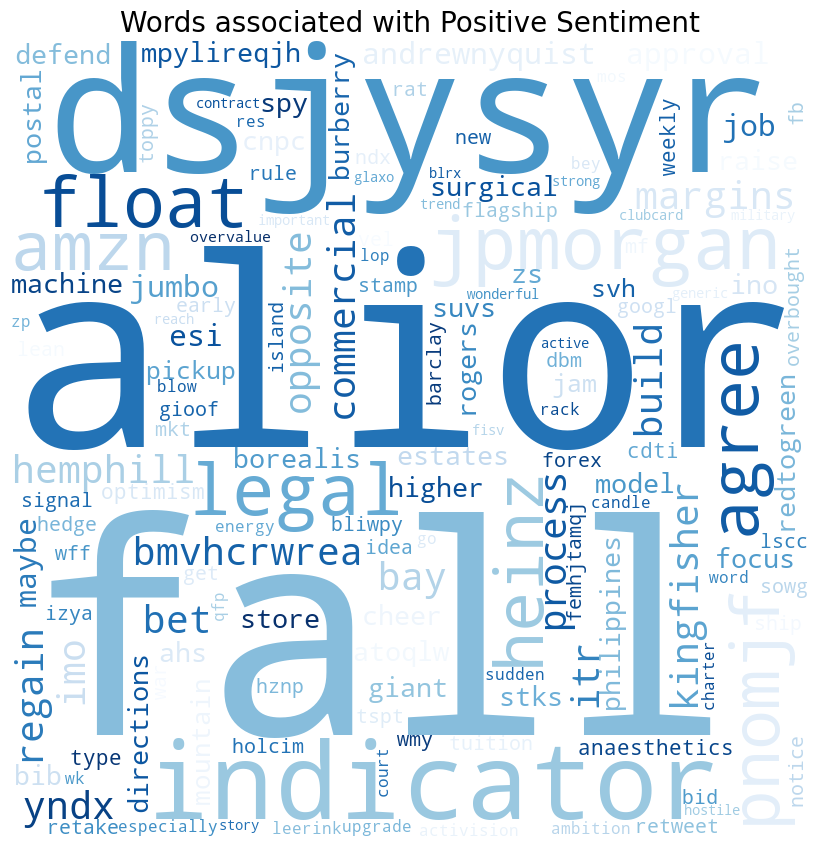

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create an empty dictionary to store the word frequencies
word_freq = {}

# Loop through the topics and add the words and probabilities to the dictionary
for index, probability in sorted(positive_sentiment_topic_dist, key=lambda tup: -1*tup[1]):
    topic_words = hdp_model.show_topic(index, topn=10)
    for word, prob in topic_words:
        word_freq[word] = prob * probability

# Create the WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='Blues').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Words associated with Positive Sentiment', fontsize=20)

# Display the plot
plt.show()

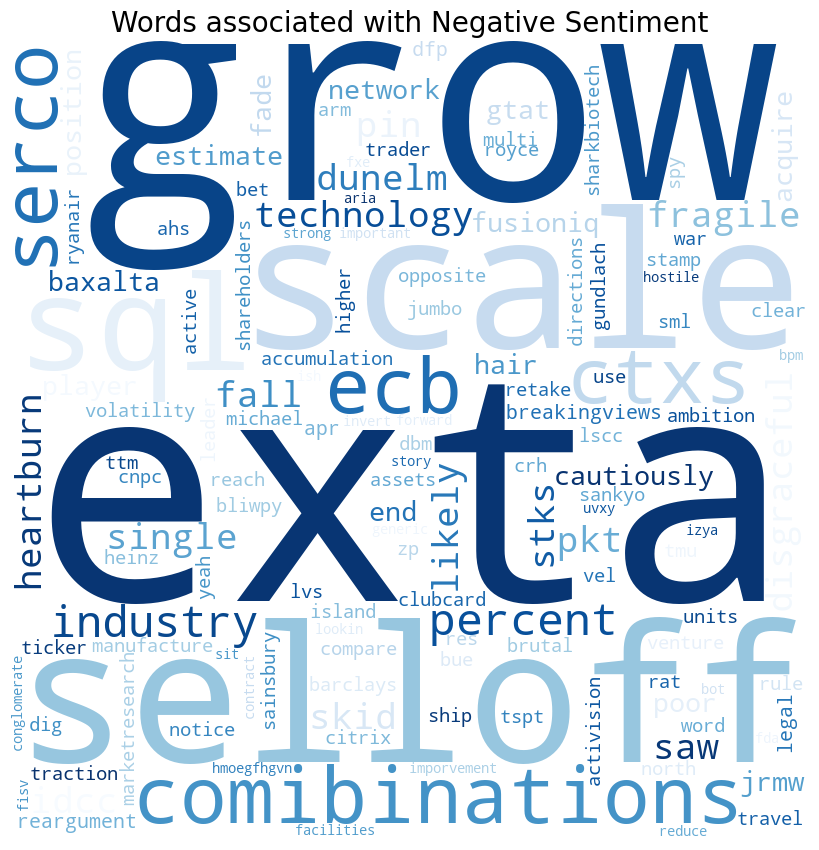

In [27]:
# Create an empty dictionary to store the word frequencies
word_freq = {}

# Loop through the topics and add the words and probabilities to the dictionary
for index, probability in sorted(negative_sentiment_topic_dist, key=lambda tup: -1*tup[1]):
    topic_words = hdp_model.show_topic(index, topn=10)
    for word, prob in topic_words:
        word_freq[word] = prob * probability

# Create the WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='Blues').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Words associated with Negative Sentiment', fontsize=20)

# Display the plot
plt.show()

## Evaluation
From reviewing these we can see that the approach has identified words that occur in each of the topics. These can give us an idea of what topics people are happy or unhappy with, but more analysis would be required to come to concrete conclusions. For example, iPad appears as a word in positive topics, this could suggest that people enjoyed use of an iPad in relation to this subject. Handset occurs as a word in the negative sentiments, this suggests that use of a handset was not good. Please note the words shown here are in their processed form that was used to train the model. As mentioned before, this approach only identifies distinct topics, to gain value from this they would need to be manually analysed by a subject matter expert who can give the topics meaningful names. In the process the effectiveness of this model can then be evaluated.